In [17]:
# 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# sc.install_pypi_package('pandas')
# sc.install_pypi_package('matplotlib')
sc.install_pypi_package('seaborn')
# sc.install_pypi_package('fsspec')
# sc.install_pypi_package('s3fs ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Merge the Hail dataset and Structure dataset

In [19]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Load the data

In [20]:
s3_uri = 's3a://noaa-swdi-pds/hail-????.csv'

schema = StructType([
    StructField("ZTIME", StringType(), nullable=True),
    StructField("LON", DoubleType(), nullable=True),
    StructField("LAT", DoubleType(), nullable=True),
    StructField("WSR_ID", StringType(), nullable=True),
    StructField("CELL_ID", StringType(), nullable=True),
    StructField("RANGE", DoubleType(), nullable=True),
    StructField("AZIMUTH", DoubleType(), nullable=True),
    StructField("SEVPROP", DoubleType(), nullable=True),
    StructField("PROB", DoubleType(), nullable=True)
])

hail = (
    spark
    .read
    .csv(s3_uri, header=True, schema=schema)
    .where(F.col('LON').isNotNull())
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
s3_uri = 's3a://noaa-swdi-pds/structure-????.csv'

schema = StructType([
    StructField("ZTIME", StringType(), nullable=True),
    StructField("LON", DoubleType(), nullable=True),
    StructField("LAT", DoubleType(), nullable=True),
    StructField("WSR_ID", StringType(), nullable=True),
    StructField("CELL_ID", StringType(), nullable=True),
    StructField("RANGE", DoubleType(), nullable=True),
    StructField("AZIMUTH", DoubleType(), nullable=True),
    StructField("BASE_HEIGHT", DoubleType(), nullable=True),
    StructField("TOP_HEIGHT", DoubleType(), nullable=True),
    StructField("VIL", DoubleType(), nullable=True),
    StructField("MAX_REFLECT", DoubleType(), nullable=True),
    StructField("HEIGHT", DoubleType(), nullable=True)
])

structure = (
    spark
    .read
    .csv(s3_uri, header=True, schema=schema)
    .where(F.col('LON').isNotNull())
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Engineer datetime features

In [22]:
hail = (
    hail
    .withColumn('ZTIME', F.to_timestamp(F.col('ZTIME'), 'yyyyMMddHHmmss'))
    .withColumn('ZYEAR', F.year('ZTIME'))
    .withColumn('ZMONTH', F.month('ZTIME'))
    .withColumn('ZDAY', F.dayofyear('ZTIME'))
    .withColumn('ZHOUR', F.hour('ZTIME'))
    .withColumnRenamed('RANGE', 'RANGE_HAIL')
    .withColumnRenamed('AZIMUTH', 'AZIMUTH_HAIL')
    .withColumnRenamed('LON', 'LON_HAIL')
    .withColumnRenamed('LAT', 'LAT_HAIL')
    .withColumnRenamed('SEVPROP', 'SEVPROB')
)

structure = (
    structure
    .withColumn('ZTIME', F.to_timestamp(F.col('ZTIME'), 'yyyyMMddHHmmss'))
    .withColumn('ZYEAR', F.year('ZTIME'))
    .withColumn('ZMONTH', F.month('ZTIME'))
    .withColumn('ZDAY', F.dayofyear('ZTIME'))
    .withColumn('ZHOUR', F.hour('ZTIME'))
    .withColumnRenamed('RANGE', 'RANGE_STRUCTURE')
    .withColumnRenamed('AZIMUTH', 'AZIMUTH_STRUCTURE')
    .withColumnRenamed('LON', 'LON_STRUCTURE')
    .withColumnRenamed('LAT', 'LAT_STRUCTURE')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
hail.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['ZTIME', 'LON_HAIL', 'LAT_HAIL', 'WSR_ID', 'CELL_ID', 'RANGE_HAIL', 'AZIMUTH_HAIL', 'SEVPROB', 'PROB', 'ZYEAR', 'ZMONTH', 'ZDAY', 'ZHOUR']

In [24]:
structure.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['ZTIME', 'LON_STRUCTURE', 'LAT_STRUCTURE', 'WSR_ID', 'CELL_ID', 'RANGE_STRUCTURE', 'AZIMUTH_STRUCTURE', 'BASE_HEIGHT', 'TOP_HEIGHT', 'VIL', 'MAX_REFLECT', 'HEIGHT', 'ZYEAR', 'ZMONTH', 'ZDAY', 'ZHOUR']

## Merge the hail and structure data and filter `SEVPROB` < 0

In [25]:
merge_cols = ['WSR_ID', 'CELL_ID', 'ZYEAR', 'ZMONTH', 'ZDAY', 'ZHOUR']

merged_df = (
    hail
    .join(structure, on=merge_cols, how='inner')
    .filter(
        ((F.col('SEVPROB') >= 0) &
        (F.col('PROB') >= 0) &
        (F.col('RANGE_HAIL') >= 0) &
        (F.col('RANGE_STRUCTURE') >= 0) &
        (F.col('AZIMUTH_HAIL') >= 0) &
        (F.col('AZIMUTH_STRUCTURE') >= 0) &
        (F.col('BASE_HEIGHT') >= 0) &
        (F.col('TOP_HEIGHT') >= 0) &
        (F.col('VIL') >= 0) &
        (F.col('MAX_REFLECT') >= 0) &
        (F.col('HEIGHT') >= 0) &
        (F.col('TOP_HEIGHT') >= 0))
       & (F.col('ZYEAR') >= 2010)
    )
    .withColumn('LON', (F.col('LON_HAIL') + F.col('LON_STRUCTURE'))/2)
    .withColumn('LAT', (F.col('LAT_HAIL') + F.col('LAT_STRUCTURE'))/2)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# merged_dict = {}
# merged_dict['row_count'] = merged_df.count()

In [21]:
# merged_dict['row_count']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

428113791

## Model Training

In [10]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer
from pyspark.ml.regression import GBTRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# month_si = StringIndexer(inputCol='ZMONTH', 
#                          outputCol='ZMONTH_indexed')
# month_si_trained = month_si.fit(merged_df)
# merged_df = month_si_trained.transform(merged_df)

# # day_si = StringIndexer(inputCol='ZDAY', 
# #                        outputCol='ZDAY_indexed')
# # day_si_trained = day_si.fit(merged_df)
# # merged_df = day_si_trained.transform(merged_df)

# hour_si = StringIndexer(inputCol='ZHOUR', 
#                         outputCol='ZHOUR_indexed')
# hour_si_trained = hour_si.fit(merged_df)
# merged_df = hour_si_trained.transform(merged_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
features = ['LON', 'LAT', 'ZYEAR', 'ZMONTH', 'ZHOUR', 'RANGE_HAIL', 'AZIMUTH_HAIL',
            'RANGE_STRUCTURE', 'AZIMUTH_STRUCTURE', 'BASE_HEIGHT', 'TOP_HEIGHT', 'VIL', 'MAX_REFLECT', 'HEIGHT']

va = VectorAssembler(
    inputCols=features,
    outputCol='features'
)

merged_df = va.transform(merged_df)
merged_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[WSR_ID: string, CELL_ID: string, ZYEAR: int, ZMONTH: int, ZDAY: int, ZHOUR: int, ZTIME: timestamp, LON_HAIL: double, LAT_HAIL: double, RANGE_HAIL: double, AZIMUTH_HAIL: double, SEVPROB: double, PROB: double, ZTIME: timestamp, LON_STRUCTURE: double, LAT_STRUCTURE: double, RANGE_STRUCTURE: double, AZIMUTH_STRUCTURE: double, BASE_HEIGHT: double, TOP_HEIGHT: double, VIL: double, MAX_REFLECT: double, HEIGHT: double, LON: double, LAT: double, features: vector]

In [12]:
# seed = 143

# df_train, df_test = merged_df.randomSplit([0.7, 0.3], seed=seed)
# # df_train.cache()
# # df_test.cache()

# model = RandomForestRegressor(featuresCol='features', labelCol='SEVPROB', predictionCol='prediction')

# model_trained = model.fit(df_train)

# predictions = model_trained.transform(df_test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Model Evaluation

In [13]:
model.save('s3://bdcc2023-studio-calbao1/e-7RR2MRIR6Y0XJQ9X5DRQBRYLX/rf-untrained-2010-new')
model_trained.save('s3://bdcc2023-studio-calbao1/e-7RR2MRIR6Y0XJQ9X5DRQBRYLX/rf-trained-2010-new')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
seed = 143

df_train, df_test = merged_df.randomSplit([0.7, 0.3], seed=seed)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
from pyspark.ml.regression import RandomForestRegressionModel
model_trained = RandomForestRegressionModel.load('s3://bdcc2023-studio-calbao1/e-7RR2MRIR6Y0XJQ9X5DRQBRYLX/rf-trained-2010-new')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
feat_importance = pd.DataFrame(sorted(zip(features, tuple(model_trained.featureImportances)), key=lambda x: -x[1]),
                               columns=['feat', 'importance'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
fig.savefig('s3://bdcc2023-studio-calbao1/e-7RR2MRIR6Y0XJQ9X5DRQBRYLX/feat_imp.jpg', dpi=200)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
[Errno 2] No such file or directory: 's3://bdcc2023-studio-calbao1/e-7RR2MRIR6Y0XJQ9X5DRQBRYLX/feat_imp.jpg'
Traceback (most recent call last):
  File "/mnt/yarn/usercache/livy/appcache/application_1685643960186_0003/container_1685643960186_0003_01_000001/tmp/1685682739731-0/lib/python3.7/site-packages/matplotlib/figure.py", line 3058, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/mnt/yarn/usercache/livy/appcache/application_1685643960186_0003/container_1685643960186_0003_01_000001/tmp/1685682739731-0/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 2325, in print_figure
    **kwargs)
  File "/mnt/yarn/usercache/livy/appcache/application_1685643960186_0003/container_1685643960186_0003_01_000001/tmp/1685682739731-0/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1648, in wrapper
    return func(*args, **kwargs)
  File "/mnt/yarn/usercache/livy/appcache/application_1685643960186_0003/container_1685643960186_0003_0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

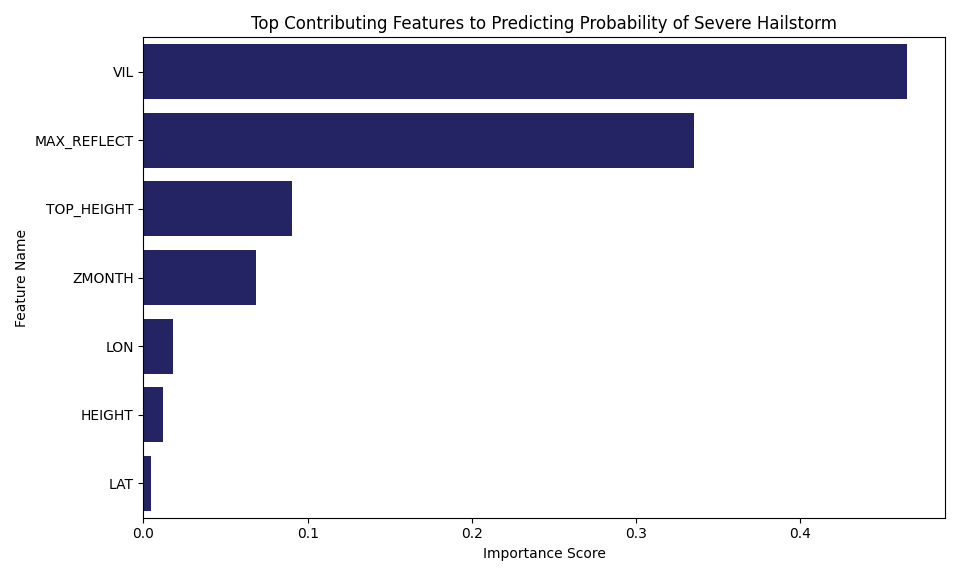

In [54]:
fig = plt.figure(figsize=(6.4*1.5, 4.8*1.2))
sns.barplot(data=feat_importance.iloc[:7], y='feat', x='importance', color='midnightblue')
plt.ylabel('Feature Name')
plt.xlabel('Importance Score')
plt.title('Top Contributing Features to Predicting Probability of Severe Hailstorm')
plt.tight_layout()
# plt.savefig('s3://bdcc2023-studio-calbao1/e-7RR2MRIR6Y0XJQ9X5DRQBRYLX/feat_imp.jpg', dpi=200)
%matplot plt

In [14]:
predictions = (
    model_trained
    .transform(df_test)
    .withColumn('prediction_rounded', F.round(F.col('prediction') / 10) * 10)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
r2_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SEVPROB', metricName='r2')
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SEVPROB', metricName='rmse')
mae_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SEVPROB', metricName='mae')

r2 = r2_evaluator.evaluate(predictions)  
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print(f'R2 = {r2}')
print(f'RMSE = {rmse}')
print(f'MAE  = {mae}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

R2 = 0.3965168839601919
RMSE = 14.333321080268508
MAE  = 8.87812081823531

In [17]:
'hello'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'hello'